In [1]:
import sys
print(sys.executable)

/home/persists/Documents/Uni/classifaas-results/.venv/bin/python


In [3]:
from helpers.benchmark import load_records_from_directory
from helpers.azure import load_all_billed_azure, inject_billed_azure
from helpers.gcp import load_all_billed_gcp, inject_billed_gcp
from helpers.aws import load_all_billed_aws, inject_billed_aws
from helpers.alibaba import load_all_billed_alibaba, inject_billed_alibaba



LOG_DIR = "data/stage_a"
df = load_records_from_directory(LOG_DIR)
print("loaded records:", len(df))

# billed_alibaba_df = load_all_billed_alibaba(f"{LOG_DIR}/alibaba")
# df = inject_billed_alibaba(df, billed_alibaba_df)

# billed_azure_df = load_all_billed_azure(f"{LOG_DIR}/azure")
# df = inject_billed_azure(df, billed_azure_df)

# billed_gcp_df = load_all_billed_gcp(f"{LOG_DIR}/gcp")
# df = inject_billed_gcp(df, billed_gcp_df)

# billed_aws_df = load_all_billed_aws(f"{LOG_DIR}/aws")
# df = inject_billed_aws(df, billed_aws_df)



loaded records: 324863


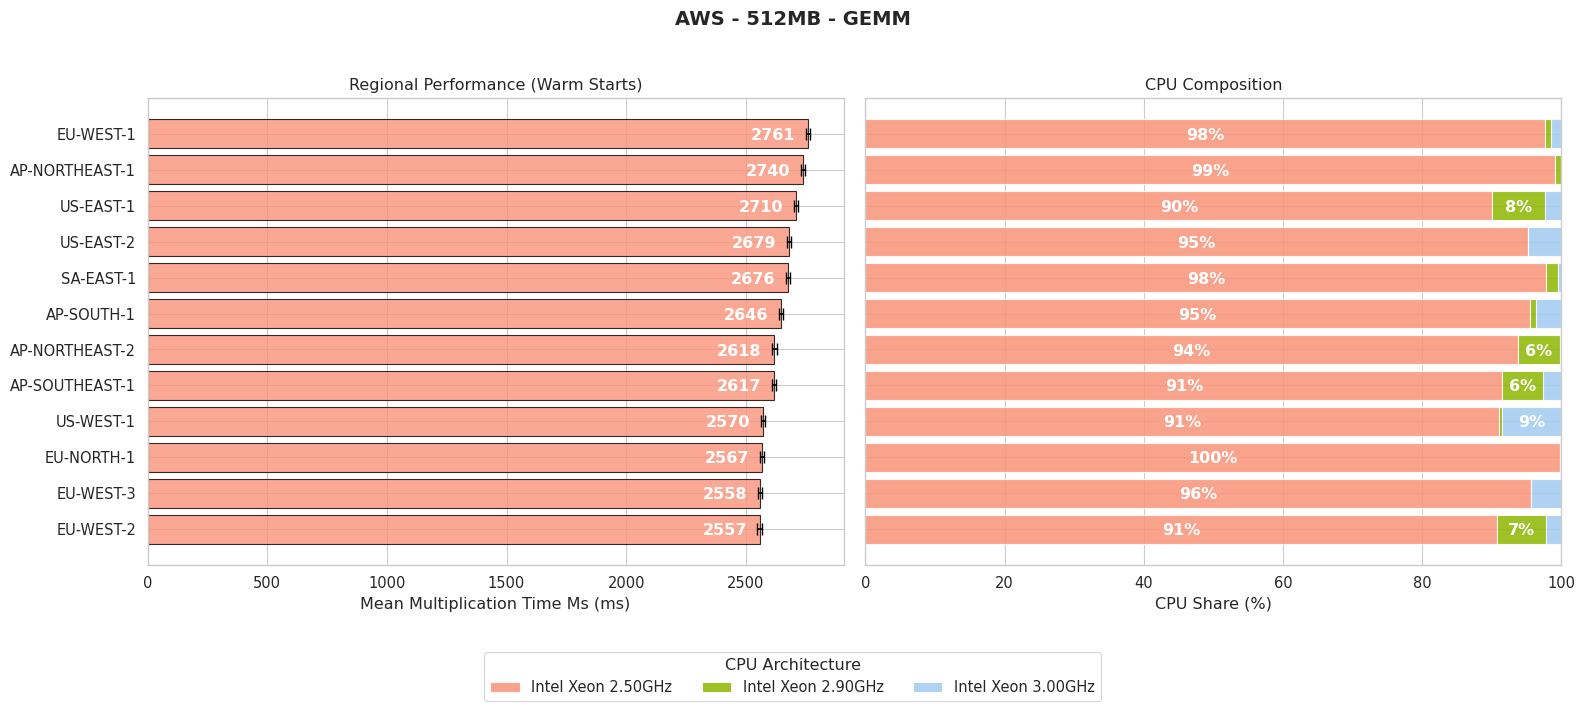

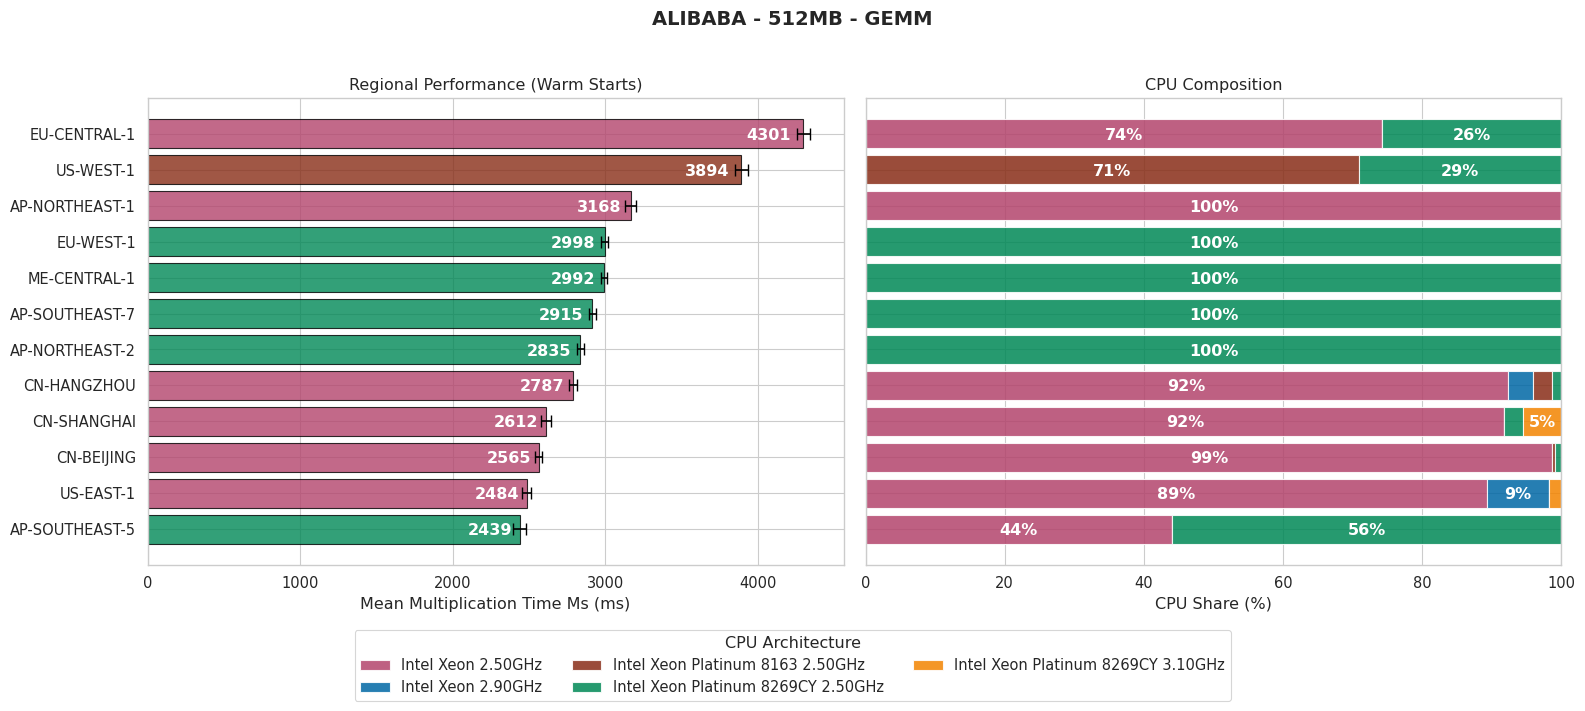

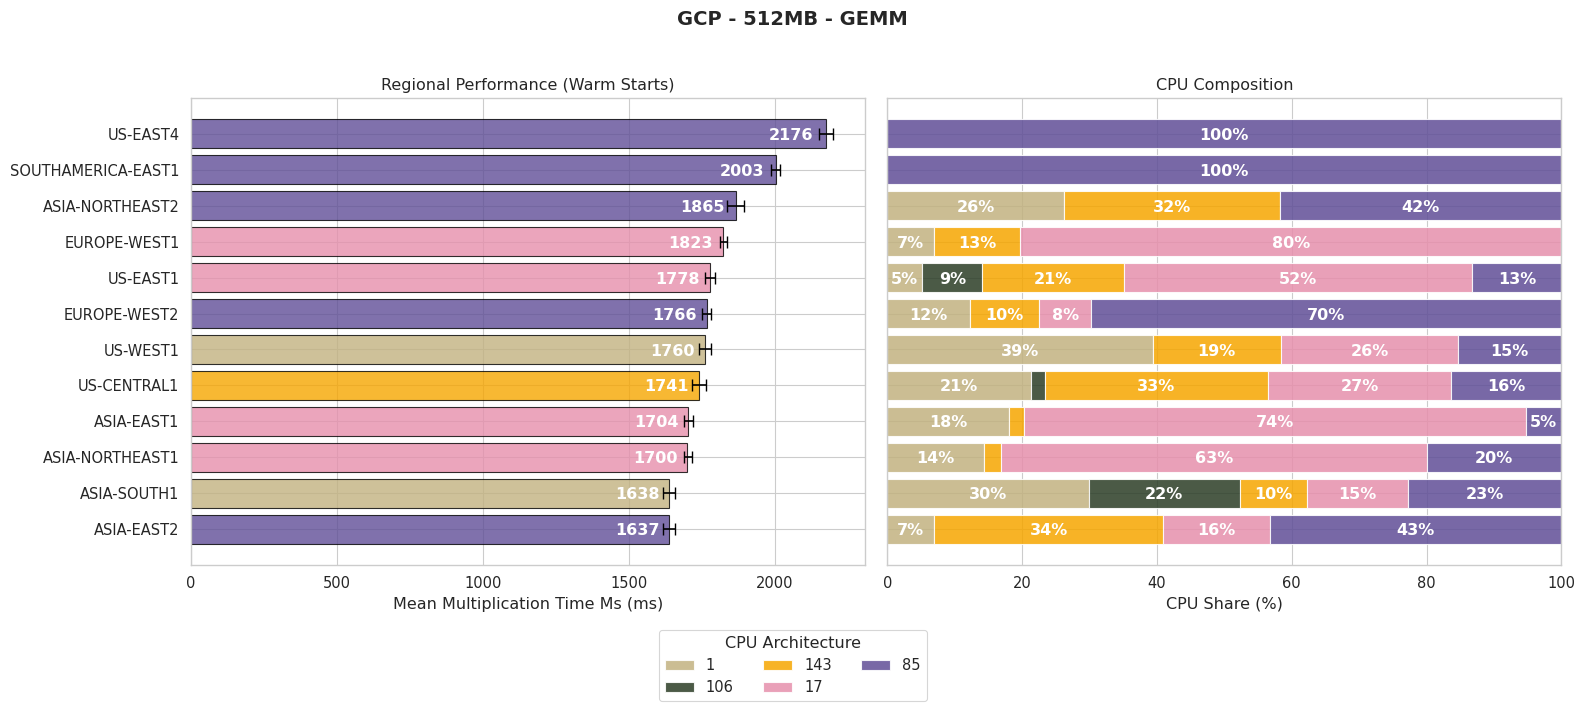

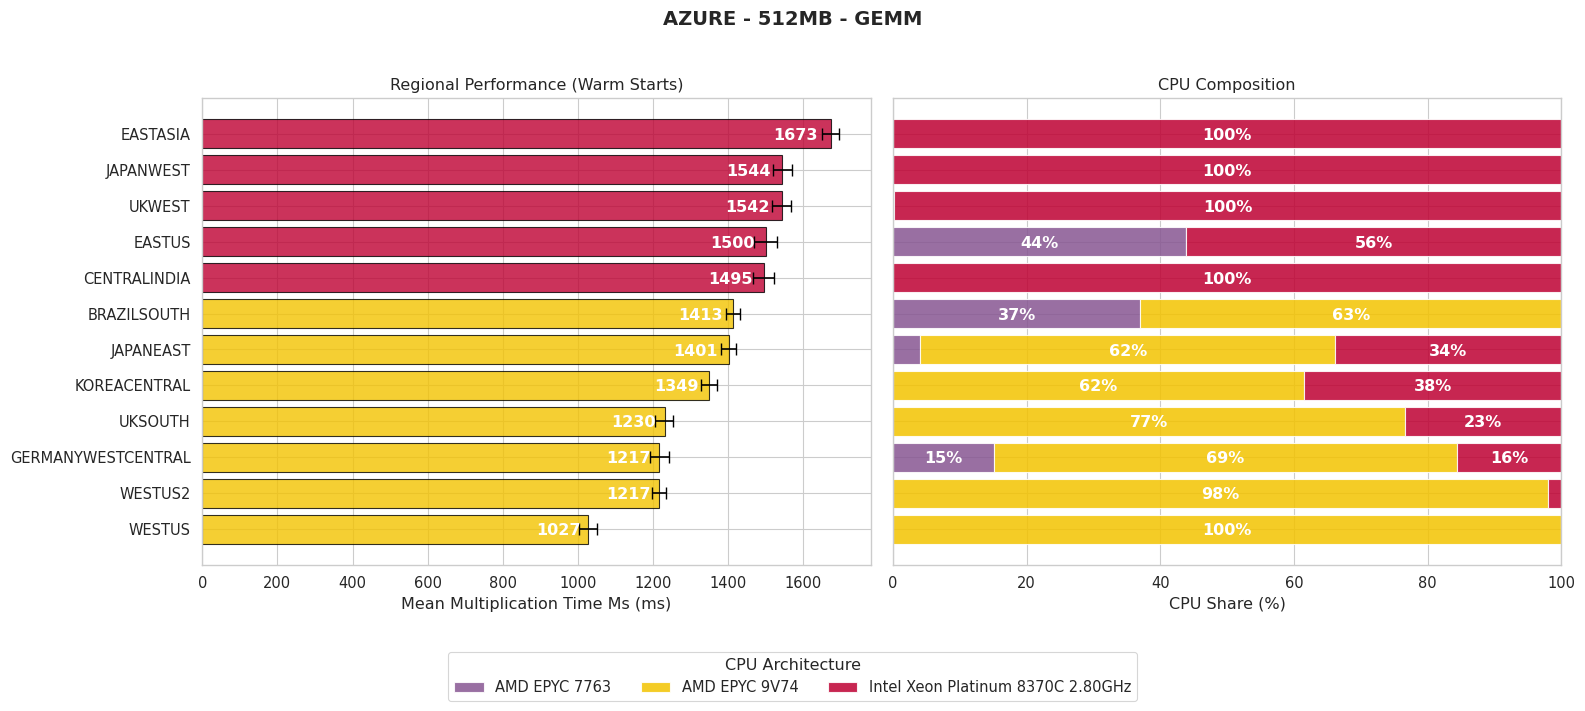

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- UPDATED IMPORT: Including get_cpu_palette ---
from helpers.cpus import clean_cpu_string, shorten_cpu_name, get_cpu_palette

# Set a professional plotting theme
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

# ==============================================================================
# 1. STATISTICAL HELPER
# ==============================================================================
def get_bootstrap_ci(data, n_bootstraps=2000, ci=0.95):
    data = np.array(data)
    data = data[~np.isnan(data)]
    if len(data) < 2: return 0.0, 0.0
    
    rng = np.random.default_rng()
    indices = rng.integers(0, len(data), (n_bootstraps, len(data)))
    resampled_data = data[indices]
    boot_means = np.mean(resampled_data, axis=1)
    
    lower_p = (1 - ci) / 2 * 100
    upper_p = (1 + ci) / 2 * 100
    ci_low, ci_high = np.percentile(boot_means, [lower_p, upper_p])
    
    return np.mean(data) - ci_low, ci_high - np.mean(data)

# ==============================================================================
# 2. MAIN VISUALIZATION FUNCTION
# ==============================================================================
def create_regional_performance_cpu_analysis(df, provider="aws", memory_size=512, 
                                             benchmark_type="gemm"):
    
    # Filter Base Data
    df_base = df[
        (df["provider"] == provider) &
        (df["memory_size_mb"] == memory_size) &
        (df["benchmark_type"] == benchmark_type)
    ].copy()
    
    if df_base.empty:
        print(f"No data found for {provider} {memory_size}MB")
        return

    # --- STEP 1: APPLY CLEANING ---
    df_base["cpu_type"] = df_base["cpu_type"].apply(clean_cpu_string)
    # ------------------------------

    # Metric Mapping
    metric_map = {
        "gemm": "multiplication_time_ms",
        "aesCtr": "encrypt_time_ms",
        "gzip": "compress_time_ms",
        "sha256": "hash_time_ms"
    }
    metric = metric_map.get(benchmark_type, "runtime_ms")
    metric_label = metric.replace('_', ' ').title()
    
    # Filter to complete groups
    invocation_counts = df_base.groupby("instance_id")["invocation_count"].nunique()
    valid_instances = invocation_counts[invocation_counts == 4].index
    df_filtered = df_base[df_base["instance_id"].isin(valid_instances)].copy()
    
    if len(df_filtered) == 0: return df_filtered
    
    regions = sorted(df_filtered["region"].unique())
    n_regions = len(regions)

    # Calculate CPU Stats
    all_cpu_types = sorted(df_filtered["cpu_type"].unique())
    
    # --- STEP 2: GET CONSISTENT COLORS (THE FIX) ---
    # Pass provider context to ensure AWS and Alibaba get distinct colors
    cpu_colors = get_cpu_palette(all_cpu_types, provider=provider)
    # -----------------------------------------------
     
    
    cpu_dist_data = []
    region_dominant_cpu = {}
    
    for region in regions:
        df_region = df_filtered[df_filtered["region"] == region]
        cpu_counts = df_region["cpu_type"].value_counts()
        total = len(df_region)
        
        region_dist = {'region': region}
        for cpu_type in all_cpu_types:
            region_dist[cpu_type] = (cpu_counts.get(cpu_type, 0) / total * 100)
            
        cpu_dist_data.append(region_dist)
        if not cpu_counts.empty:
            region_dominant_cpu[region] = cpu_counts.idxmax()
        else:
            # Fallback if no data
            region_dominant_cpu[region] = all_cpu_types[0] if all_cpu_types else "Unknown"

    cpu_dist_df = pd.DataFrame(cpu_dist_data).set_index('region')

    # Performance Stats (Warm Starts)
    df_warm = df_filtered[df_filtered["invocation_count"] >= 2].copy()
    
    regional_stats = df_warm.groupby("region").agg({
        metric: ['mean', 'median', 'std', 'count']
    })
    regional_stats.columns = ['mean', 'median', 'std', 'count']
    
    ci_results = df_warm.groupby("region")[metric].apply(
        lambda x: get_bootstrap_ci(x, n_bootstraps=2000, ci=0.95)
    )
    regional_stats['err_low'] = ci_results.apply(lambda x: x[0])
    regional_stats['err_high'] = ci_results.apply(lambda x: x[1])

    # Sort
    regional_stats = regional_stats.sort_values('mean', ascending=True)
    regions_sorted = regional_stats.index.tolist()
    cpu_dist_df = cpu_dist_df.reindex(regions_sorted)
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, max(6, n_regions * 0.6)), 
                                    gridspec_kw={'width_ratios': [1, 1]})
    
    y_pos = np.arange(n_regions)
    
    # Left Panel
    asymmetric_error = [regional_stats['err_low'].values, regional_stats['err_high'].values]
    
    # Map the dominant CPU of the region to our global color palette
    performance_bar_colors = []
    for r in regions_sorted:
        dom_cpu = region_dominant_cpu.get(r)
        # Fallback to grey if something goes wrong, but get_cpu_palette handles most cases
        performance_bar_colors.append(cpu_colors.get(dom_cpu, "#7f8c8d"))

    bars = ax1.barh(y_pos, regional_stats['mean'], color=performance_bar_colors, alpha=0.8, edgecolor='black')
    ax1.errorbar(regional_stats['mean'], y_pos, xerr=asymmetric_error, fmt='none', ecolor='black', capsize=4)
    
    for i, (bar, val) in enumerate(zip(bars, regional_stats['mean'])):
        ax1.text(bar.get_width() * 0.98, bar.get_y() + bar.get_height()/2, f'{val:.0f}', ha='right', va='center_baseline', color='white', fontweight='bold')

    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([r.upper() for r in regions_sorted])
    ax1.set_xlabel(f"Mean {metric_label} (ms)")
    ax1.set_title("Regional Performance (Warm Starts)")

    # Right Panel
    left_positions = np.zeros(n_regions)
    for cpu_type in all_cpu_types:
        if cpu_type in cpu_dist_df.columns:
            values = cpu_dist_df[cpu_type].values
            
            # --- STEP 3: USE HELPER SHORTENER ---
            cpu_label = shorten_cpu_name(cpu_type, 35)
            # ------------------------------------
            
            # Use the CONSISTENT COLOR for the stacked bars
            bars_stack = ax2.barh(y_pos, values, left=left_positions, label=cpu_label, 
                                color=cpu_colors[cpu_type], alpha=0.85, edgecolor='white')
            
            for i, (bar, val) in enumerate(zip(bars_stack, values)):
                if val > 5:
                    ax2.text(left_positions[i] + val/2, bar.get_y() + bar.get_height()/2, f'{val:.0f}%', ha='center', va='center_baseline', fontweight='bold', color='white')
            left_positions += values

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([])
    ax2.set_xlabel("CPU Share (%)")
    ax2.set_title("CPU Composition")
    
    # Legend
    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, title='CPU Architecture', loc='lower center', bbox_to_anchor=(0.5, 0.01), ncol=3)
    
    fig.suptitle(f"{provider.upper()} - {memory_size}MB - {benchmark_type.upper()}", fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.12, 1, 0.96])

    import os
    OUT_DIR = "../holy/plots/StageA"
    os.makedirs(OUT_DIR, exist_ok=True)
    plt.savefig(f"{OUT_DIR}/{provider}_{memory_size}MB_{benchmark_type}_regional_cpu_performance_analysis.pdf", bbox_inches='tight')
    plt.show()

    return df_filtered
# Example usage:
# df = load_records_from_directory("your_log_directory")
df_analyzed = create_regional_performance_cpu_analysis(
    df, 
    provider="aws",  # or "aws", "gcp", "alibaba"
    memory_size=512,
    benchmark_type="gemm"
)
df_analyzed = create_regional_performance_cpu_analysis(
    df, 
    provider="alibaba",  # or "aws", "gcp", "alibaba"
    memory_size=512,
    benchmark_type="gemm"
)
df_analyzed = create_regional_performance_cpu_analysis(
    df, 
    provider="gcp",  # or "aws", "gcp", "alibaba"
    memory_size=512,
    benchmark_type="gemm"
)
df_analyzed = create_regional_performance_cpu_analysis(
    df, 
    provider="azure",  # or "aws", "gcp", "alibaba"
    memory_size=512,
    benchmark_type="gemm"
)



In [3]:
%pip install colorcet

Note: you may need to restart the kernel to use updated packages.


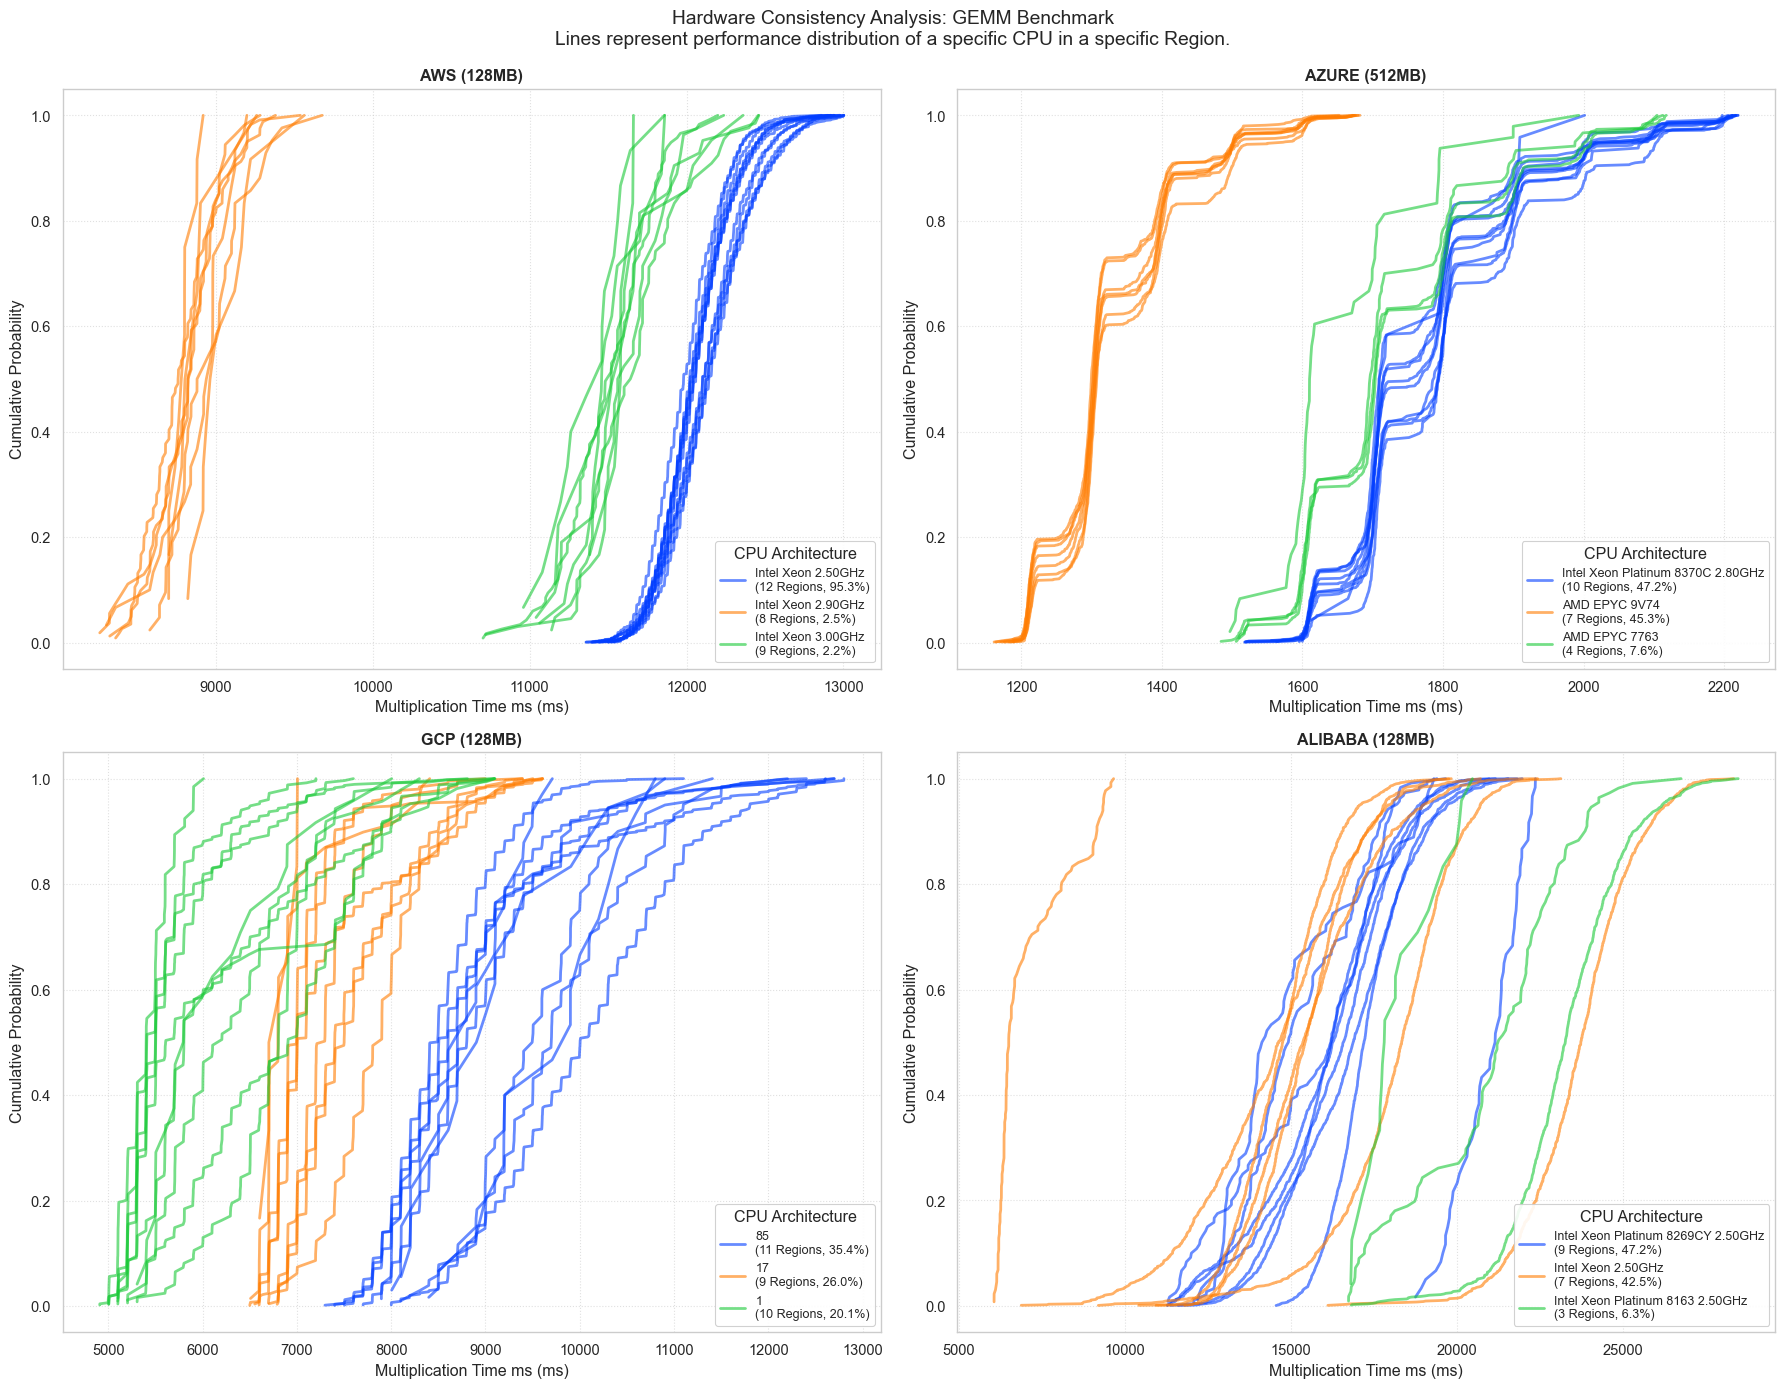

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from helpers.cpus import clean_cpu_string, shorten_cpu_name


# Set a professional plotting theme
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
# ==============================================================================
# 3. DATA FILTERING LOGIC
# ==============================================================================

def filter_complete_groups(df, provider, memory_size, benchmark_type="gemm"):
    """
    Optimized filtering:
    1. Filter by metadata
    2. Clean CPU names (MERGES DUPLICATES)
    3. Keep only complete groups (4 invs)
    4. Remove outliers (Tukey)
    """
    
    # 1. Basic Metadata Filter
    mask = (
        (df["provider"] == provider) &
        (df["memory_size_mb"] == memory_size) &
        (df["benchmark_type"] == benchmark_type)
    )
    df_filtered = df[mask].copy()
    
    if df_filtered.empty:
        return df_filtered

    # 2. Normalize CPU Names immediately
    df_filtered["cpu_type"] = df_filtered["cpu_type"].apply(clean_cpu_string)
    
    # 3. Complete Groups Filter
    inv_counts = df_filtered["instance_id"].value_counts()
    valid_ids = inv_counts[inv_counts == 4].index
    df_filtered = df_filtered[df_filtered["instance_id"].isin(valid_ids)]
    
    # 4. Outlier Detection (Tukey Method per CPU Type)
    metric = "multiplication_time_ms"
    
    def is_outlier(x):
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        return (x < lower) | (x > upper)

    if metric in df_filtered.columns:
        outlier_mask = df_filtered.groupby("cpu_type")[metric].transform(is_outlier)
        bad_instances = df_filtered.loc[outlier_mask, "instance_id"].unique()
        df_filtered = df_filtered[~df_filtered["instance_id"].isin(bad_instances)]

    # 5. Filter for Warm Starts (Inv > 1)
    df_filtered = df_filtered[df_filtered["invocation_count"] > 1]
    
    return df_filtered.copy()

def select_top_cpus(df_filtered, top_n=3, min_samples=10):
    if df_filtered.empty: return []
    
    cpu_stats = df_filtered.groupby("cpu_type").agg({"instance_id": "count"})
    cpu_stats = cpu_stats[cpu_stats["instance_id"] >= min_samples]
    selected_cpus = cpu_stats.sort_values("instance_id", ascending=False).head(top_n).index.tolist()
    
    return selected_cpus

# ==============================================================================
# 4. VISUALIZATION & ANALYSIS
# ==============================================================================

def plot_cpu_consistency_simplified(df, providers=None, memory_configs=None,
                                   benchmark_type="gemm", top_n=3, min_samples=20):
    """
    Generates ECDF plots showing CPU consistency across regions.
    """
    
    if providers is None: providers = ["aws", "azure", "gcp", "alibaba"]
    if memory_configs is None: memory_configs = {p: 512 for p in providers}
    if "timestamp" in df.columns: df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    
    metric = "multiplication_time_ms" if benchmark_type == "gemm" else "runtime_ms"
    metric_label = metric.replace('_', ' ').title().replace("Ms", "ms")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()
    
    for idx, provider in enumerate(providers):
        ax = axes[idx]
        memory_size = memory_configs.get(provider, 512)
        
        # 1. Filter Data
        df_prov = filter_complete_groups(df, provider, memory_size, benchmark_type)
        
        if df_prov.empty:
            ax.text(0.5, 0.5, f"No Data: {provider.upper()}", ha='center', transform=ax.transAxes)
            ax.axis('off')
            continue
            
        # 2. Select Top CPUs
        top_cpus = select_top_cpus(df_prov, top_n=top_n, min_samples=min_samples)
        
        if not top_cpus:
            ax.text(0.5, 0.5, "Insufficient CPU Samples", ha='center', transform=ax.transAxes)
            continue
            
        palette = sns.color_palette("bright", len(top_cpus))
        lines_for_legend = []
        labels_for_legend = []
        total_invocations = len(df_prov)
        
        for cpu_i, cpu_name in enumerate(top_cpus):
            cpu_data = df_prov[df_prov["cpu_type"] == cpu_name]
            regions = sorted(cpu_data["region"].unique())
            
            share = (len(cpu_data) / total_invocations) * 100
            cpu_clean = shorten_cpu_name(cpu_name, 40)
            color = palette[cpu_i]
            
            # --- LEGEND FIX: Track if we've added this CPU to legend yet ---
            added_to_legend = False
            
            for r_i, region in enumerate(regions):
                r_data = cpu_data[cpu_data["region"] == region][metric].sort_values()
                if len(r_data) < 5: continue
                
                y_vals = np.arange(1, len(r_data) + 1) / len(r_data)
                
                line, = ax.plot(r_data, y_vals, color=color, alpha=0.6, linewidth=2)
                
                # --- FIX: Add to legend the FIRST time we successfully plot, not just on r_i==0 ---
                if not added_to_legend:
                    lines_for_legend.append(line)
                    labels_for_legend.append(f"{cpu_clean}\n({len(regions)} Regions, {share:.1f}%)")
                    added_to_legend = True

        ax.legend(lines_for_legend, labels_for_legend, title="CPU Architecture", 
                 fontsize=9, loc="lower right", framealpha=0.9)
        
        ax.set_title(f"{provider.upper()} ({memory_size}MB)", fontweight='bold')
        ax.set_xlabel(f"{metric_label} (ms)")
        ax.set_ylabel("Cumulative Probability")
        ax.grid(True, linestyle=':', alpha=0.6)

    plt.suptitle(f"Hardware Consistency Analysis: {benchmark_type.upper()} Benchmark\n"
                 "Lines represent performance distribution of a specific CPU in a specific Region.", y=0.99)
    plt.tight_layout()
    OUT_DIR = "../holy/plots/StageA"
    plt.savefig(f"{OUT_DIR}/cpu_consistency_all_lowest_{benchmark_type}.pdf", bbox_inches='tight')
    plt.show()

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

mixed_memory_config = {
    "aws": 128,
    "gcp": 128,
    "alibaba": 128,
    "azure": 512
}

plot_cpu_consistency_simplified(
    df, 
    providers=["aws", "azure", "gcp", "alibaba"],
    memory_configs=mixed_memory_config,
    benchmark_type="gemm",
    top_n=3,
    min_samples=20
)